In [1]:
import numpy as np
import matplotlib.pyplot as plt
from da.l96 import lorenz96
from da.scheme import rk4
from da.loss import loss_rms
from da.visualize import plot_loss
from da.letkf import LETKF

In [6]:
# Lorenz96の設定
J = 40
F = 8

# parameters
p = (F,)

# 同化step
# 時間発展は0.01ごとに行う
Dt = 0.05

# モデルの遷移関数(非線形)
# 0.01ずつ時間発展させる
# Dtは同化step
def M(x, Dt):
    for i in range(int(Dt/0.01)):
        x = rk4(lorenz96, 0, x, p, 0.01)
    return x

# 単位行列
I = np.eye(J)

# 観測
H = I

# モデル誤差共分散, 最初は完全モデルを仮定
Q = np.zeros((J, J))

# 観測誤差共分散, 後で定数倍の変化をさせる.
r = 1.0
R = r*I

# 観測値と真値
end_step = -1 # 開発用
x_true = np.load('x_true_l96.npy')[:end_step]
y = np.load('x_obs_l96.npy')[:end_step]
if not np.isclose(r, 1.0):
    y = x_true + np.random.normal(loc=0, scale=np.sqrt(r), size=x_true.shape) # R = r*I

# KFの初期値
seed = 1
np.random.seed(seed)
x_0 = x_true[np.random.randint(len(x_true)-1)]

P_0 = 25*I


# ensemble size
m = 20

In [21]:
from tqdm import tqdm
X_0 = x_0 + np.random.multivariate_normal(np.zeros_like(x_0), P_0, m)  # (m, dim_x)
letkf = LETKF(M, H, R, alpha=1.03,
            c=10.0, localization='gaspari-cohn', multi_process=False)
letkf.initialize(X_0)
for y_obs in tqdm(y):
    letkf.forecast(Dt)
    letkf.update(y_obs)

x_assim = letkf.x

100%|██████████| 1439/1439 [00:09<00:00, 158.13it/s]


RMSE (time average): 0.19165378195027222


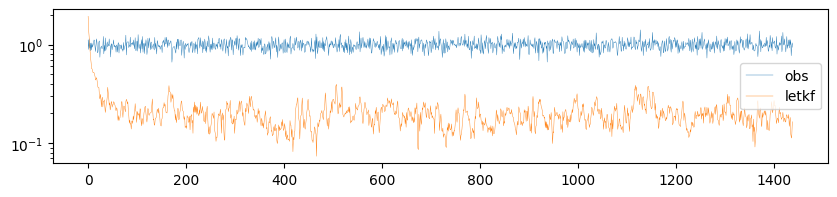

In [24]:
spin_up = 200

def compute_rmse(x):
    return loss_rms(x_true[spin_up:], x[spin_up:]).mean()

print("RMSE (time average):", compute_rmse(x_assim))

fig, ax = plt.subplots(figsize=(10, 2))
plot_loss(x_true, y, loss_rms, ax=ax, label='obs', lw=0.3)
plot_loss(x_true, x_assim, loss_rms, ax=ax, label='letkf', lw=0.3)
ax.legend()
ax.set_yscale('log')
# ax.set_ylim([0, 2])

# optimize letkf


In [5]:
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from optimize import gen_assim_func, grid_search2, gen_eval_func

KeyboardInterrupt: 

## alpha-c

In [ ]:
fixed_params = {
    "M": M,
    "H": H,
    "R": R, 
    "x_0": x_0,
    "P_0": P_0,
    "m": 8,
    "seed":seed,
    "localization": 'gaspari-cohn',
    "multi_process": False,
}

num_alpha = 2
num_c = 3
params_alpha = np.linspace(1.03-0.02, 1.03+0.02, num=num_alpha)
params_c = np.arange(num_c)*(2/5) + 10.0
n_process = 6
# try:
#     df = pd.read_csv('../data/letkf_alpha_c_detail.csv', index_col=0, header=0)
# except:
# evaluate = gen_eval_func(LETKF, fixed_params, y, dt, compute_rmse)
def evaluate(params):
    instance = LETKF(**{**fixed_params, **params})
    print(params)
    for y_obs in tqdm(y):
        instance.forecast(Dt)
        instance.update(y_obs)
    return compute_rmse(instance.x)

df = grid_search2(evaluate, "alpha", params_alpha, "c", params_c, n_process)
df.to_csv('../data/letkf_alpha_c_detail.csv')

plt.figure(figsize=(8, 8))
sns.heatmap(df, annot=True, fmt=".4f")

6
{'alpha': 1.01, 'c': 10.0}{'alpha': 1.01, 'c': 10.8}{'alpha': 1.01, 'c': 10.4}{'alpha': 1.05, 'c': 10.0}{'alpha': 1.05, 'c': 10.4}{'alpha': 1.05, 'c': 10.8}







  0%|          | 0/1439 [00:00<?, ?it/s]

KeyboardInterrupt: 

# m-c

letkf_m_c


  3%|▎         | 40/1439 [00:02<01:16, 18.21it/s]/Users/sakajolabtakeda/Locals/code/github/data_assimilation_py/code/letkf.py:126: ComplexWarning: Casting complex values to real discards the imaginary part
  self.X[:, i] = self._transform_each(i, dy, dY, dXf)
  1%|          | 13/1439 [00:00<01:38, 14.53it/s]]/Users/sakajolabtakeda/Locals/code/github/data_assimilation_py/code/letkf.py:126: ComplexWarning: Casting complex values to real discards the imaginary part
  self.X[:, i] = self._transform_each(i, dy, dY, dXf)
  0%|          | 7/1439 [00:00<01:45, 13.62it/s]/Users/sakajolabtakeda/Locals/code/github/data_assimilation_py/code/letkf.py:126: ComplexWarning: Casting complex values to real discards the imaginary part
  self.X[:, i] = self._transform_each(i, dy, dY, dXf)
100%|██████████| 1439/1439 [01:42<00:00, 14.07it/s]


<Axes: >

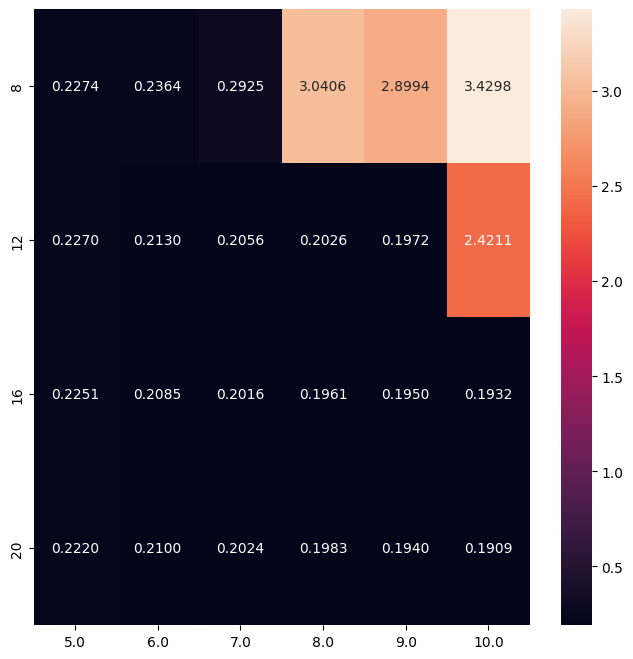

In [ ]:
# TODO: multiprocess対応
fixed_params = {
    "M": M,
    "H": H,
    "R": R, 
    "x_0": x_0,
    "P_0": P_0,
    "alpha": 1.03,
    "seed":seed,
    "localization": 'gaspari-cohn',
    "multi_process": False,
}

params_m = [8, 12, 16, 20]
params_c = [5., 6., 7., 8., 9., 10.]
n_multi = 4
multi_type="process"
target_filename = 'letkf_m_c'
print(target_filename)

try:
    df = pd.read_csv(f'../data/{target_filename}.csv', index_col=0, header=0)
except:
    def evaluate(params):
        instance = LETKF(**{**fixed_params, **params})
        for y_obs in tqdm(y):
            instance.forecast(dt)
            instance.update(y_obs)
        return compute_rmse(instance.x)
    df = grid_search2(evaluate, "m", params_m, "c", params_c, n_multi, multi_type)
    df.to_csv(f'../data/{target_filename}.csv')

plt.figure(figsize=(8, 8))
sns.heatmap(df, annot=True, fmt=".4f")